In [23]:
import os
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

In [24]:
def parse_file(path_file):
    with open(path_file, 'rb') as f:
        data = f.readlines()
    voltage_list = []
    current_list = []
    for number, string in tqdm(enumerate(data[8:]), total=len(data[8:])):
        clean_string = str(str(string).split("'")[1]).rstrip().strip().replace("\\n", '')
        voltage = clean_string.split(',')[0]
        current = clean_string.split(',')[1]
        voltage_list.append(float(voltage))
        current_list.append(float(current))
    tables, last_index = [], 0
    for i in range(len(voltage_list)):
        if (voltage_list[i] == 1.0) & (i != 0):
            tables.append(pd.DataFrame({'current': current_list[last_index:i],
                                        'voltage': voltage_list[last_index:i]}))
            last_index = i
    return tables

In [25]:
import os
import numpy as np
all_tables = []
all_labels = []
dir_path = '/Users/rodiongolovinsky/Downloads/data/external/generated_dataset_version_1'
for file in tqdm(os.listdir(dir_path)):
    if file.endswith('all_solutions.txt'):
        low_conc = float(file.split("_")[1])
        high_conc = float(file.split("_")[2])
        for amount, one in enumerate(parse_file(os.path.join(dir_path, file))):
            all_tables.append(one)
        range_conc = np.linspace(low_conc, high_conc, num=amount+1)
        for conc in range_conc:
            all_labels.append(conc)
print(len(all_tables))
print(len(all_labels))

100%|██████████| 13/13 [00:03<00:00,  4.19it/s]

6993
6993


In [26]:
lengths = []

for table in all_tables:
    if len(table) == 213:
        MINIMUM = table
    if len(table) == 280:
        MAXIMUM = table
    lengths.append(len(table))
max(lengths), min(lengths)

(280, 212)

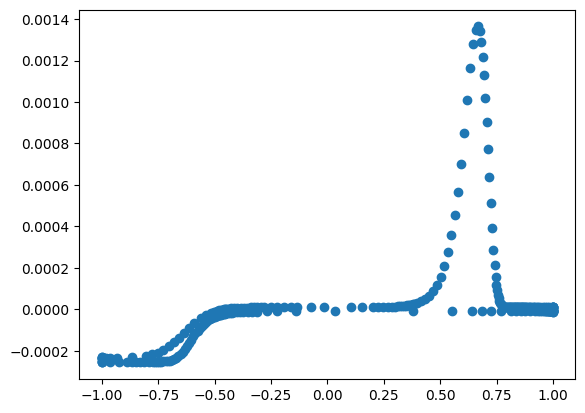

In [27]:
import matplotlib.pyplot as plt

plt.scatter(MAXIMUM['voltage'], MAXIMUM['current'])

In [28]:
min(MINIMUM.voltage)

-0.9999970346468522

In [37]:
import numpy as np
from scipy.interpolate import interp1d


def interpolation_for_cycle(df):
    difference = 280 - len(df)
    if difference == 0:
        return df
    elif difference != 0:
        half_one = round(difference / 2)
        half_two = difference - half_one
        voltage = df.voltage.tolist()
        current = df.current.tolist()
        low_index = [i for i, v in enumerate(df.voltage.tolist()[10:50]) if v < -0.5][-1]
        high_index = [i for i, v in enumerate(df.voltage.tolist()[67:200]) if v > -0.5][-1]
        cubic_interpoloate_function_low = interp1d(voltage[1:50], current[1:50], kind='cubic')
        cubic_interpoloate_function_high = interp1d(voltage[90:200], current[90:200], kind='cubic')
        xnew_low = np.linspace(-0.5, 0.90, num=half_one, endpoint=True)
        xnew_high = np.linspace(-0.5, 0.25, num=half_two, endpoint=True)
        ynew_low = cubic_interpoloate_function_low(xnew_low)
        ynew_high = cubic_interpoloate_function_high(xnew_high)
        for volt, curr in zip(xnew_low, ynew_low):
            voltage.insert(low_index, volt)
            current.insert(low_index, curr)
            low_index += 1
        for volt, curr in zip(xnew_high, ynew_high):
            voltage.insert(high_index, volt)
            current.insert(high_index, curr)
            high_index += 1
        # plt.plot(voltage, current, 'o', xnew_low, ynew_low, '--', xnew_high, ynew_high, '-')
        # plt.legend(['Original Data', 'Cubic Interpolate'], loc='best')
        return pd.DataFrame(data={'voltage': voltage, 'current': current})

In [38]:
result_rows = []
for table in all_tables:
    result_rows.append(interpolation_for_cycle(table)['current'])
    print(len(table))
result = pd.DataFrame(data=result_rows)
result

ValueError: Expect x to not have duplicates